In [11]:
import torch
import faces_model
from PIL import Image
# import data
import torchvision.transforms as transforms
from torch.autograd import Variable
from open_face_model import OpenFace
import matplotlib.pyplot as plt
import numpy as np
from datasets import celebA

import matplotlib.pyplot as plt

import torchvision

import torch.nn as nn

from data_utils import *

In [12]:
class ZeroPadBottom(object):
    ''' Zero pads batch of image tensor Variables on bottom to given size. Input (B, C, H, W) - padded on H axis. '''
    def __init__(self, size, use_gpu=True):
        self.size = size
        self.use_gpu = use_gpu
        
    def __call__(self, sample):
        B, C, H, W = sample.size()
        diff = self.size - H
        padding = Variable(torch.zeros(B, C, diff, W), requires_grad=False)
        if self.use_gpu:
            padding = padding.cuda()
        zero_padded = torch.cat((sample, padding), dim=2)
        return zero_padded

In [13]:
f_model = OpenFace(True, 0)
f_model.load_state_dict(torch.load('./pretrained_model/openface.pth'))
f_model = f_model.eval()

In [14]:
model = torch.load('final_models/simpsons/1543780806_344_61.tar')

In [16]:
train_set = celebA.CelebA(data_dir = '/home/rbnext29/dt/data/celebA/images', annotations_dir='/home/rbnext29/dt/data/celebA/annotations', split='train', transform = transforms.Compose([ResizeTransform(96)]))

In [17]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True) #TODO: why does shuffle give out of bounds indices?

In [18]:
data_iter = iter(train_loader)
img_tens = data_iter.next()
img_tens = img_tens.cuda()
img_v = Variable(img_tens, requires_grad=False)
f, f_736 = f_model(img_v)
print(f.size(), f_736.size())

(torch.Size([1, 128]), torch.Size([1, 736]))


In [19]:
s_G = model['G_model'](torch.cat((f, f_736), dim=1))
up96 = nn.Upsample(size=(96,96), mode='bilinear')
s_G = up96(s_G)
s_G = s_G.cpu().data
unnorm_emoji = UnNormalizeRangeTanh()
res = unnorm_emoji(s_G[:16])

/root/anaconda2/envs/cs7643/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/root/anaconda2/envs/cs7643/lib/python2.7/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [20]:
npimg = torchvision.utils.make_grid(res, nrow=4).numpy()
npimg = np.transpose(npimg, (1, 2, 0)) 
zero_array = np.zeros(npimg.shape)
one_array = np.ones(npimg.shape)
npimg = np.minimum(npimg,one_array)
npimg = np.maximum(npimg,zero_array)

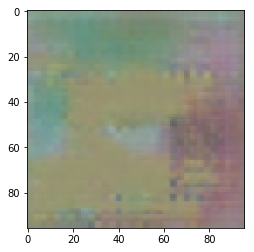

In [21]:
plt.imshow(npimg)

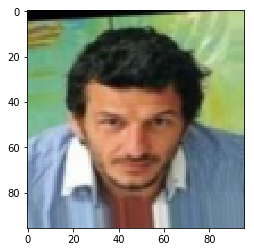

In [22]:
npimg2 = torchvision.utils.make_grid(img_tens.cpu(), nrow=4).numpy()
npimg2 = np.transpose(npimg2, (1, 2, 0)) 
zero_array2 = np.zeros(npimg2.shape)
one_array2 = np.ones(npimg2.shape)
npimg2 = np.minimum(npimg2,one_array2)
npimg2 = np.maximum(npimg2,zero_array2)
plt.imshow(npimg2)

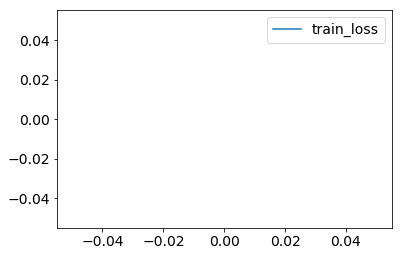

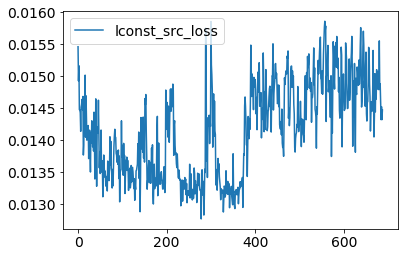

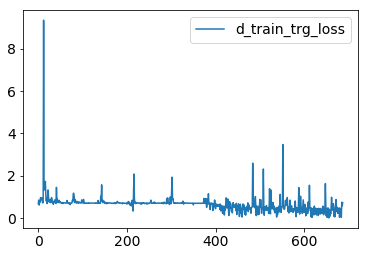

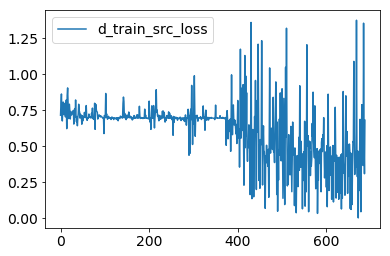

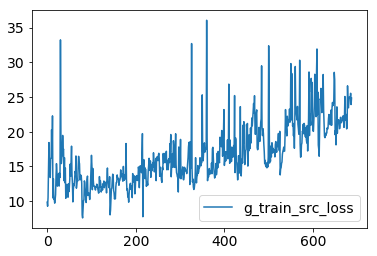

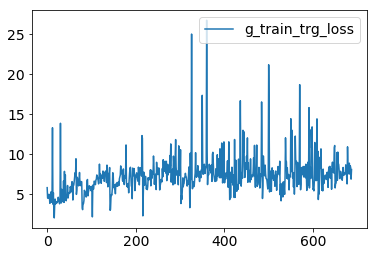

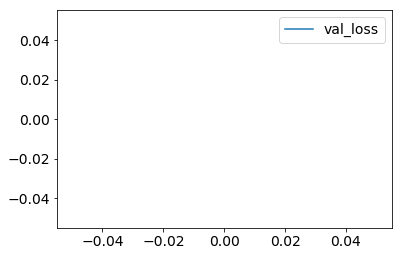

In [23]:
import matplotlib
plt.figure()
matplotlib.rcParams['font.size'] = 14
for key in model:
    if 'loss' in key and model[key] is not None:
        y = model[key][2:]
        x = np.arange(0, 11450, 50)
        plt.plot(y,label=key)
        plt.legend()
#         plt.ylabel('Loss')
#         plt.xlabel('Batches (size 128)')
        plt.show()